# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
train = pd.read_csv('/content/drive/MyDrive/pcm2.5_Kaggle-competition/train.csv')
test = pd.read_csv('/content/drive/MyDrive/pcm2.5_Kaggle-competition/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np



# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('train.csv')

# 1. Parse the date and set as index
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)
df.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

# 2. Handle missing values (forward fill)
df.fillna(method='ffill', inplace=True)

# 3. Select features and target
features = df.drop(columns='PM2.5')
target = df['PM2.5']

# 4. Normalize the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# 5. Create sequences (e.g., 24-hour window to predict next hour)
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# 6. Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False
)

# Optional: Print shapes for verification
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Model architecture
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    LSTM(256, return_sequences=True, activation='tanh'),  # Increased units
    LayerNormalization(),
    Dropout(0.3),  # Increased dropout

    LSTM(128, return_sequences=True, activation='tanh'),  # Increased units
    LayerNormalization(),
    Dropout(0.3),  # Increased dropout

    LSTM(64, return_sequences=False, activation='tanh'),
    LayerNormalization(),
    Dropout(0.3),  # Increased dropout

    Dense(1)
])

# Choose optimizer with a larger learning rate
optimizer = Adam(learning_rate=0.001)  # Increased learning rate

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # Use built-in RMSE metric
)

# Display the model architecture
model.summary()

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,  # Increased epochs
    batch_size=32,  # Adjusted batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 1, 256)         │       272,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (None, 1, 256)         │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, 1, 128)         │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_17          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,873 (1.98 MB)

 Trainable params: 519,873 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 11986.5596 - root_mean_squared_error: 109.0734 - val_loss: 9041.9287 - val_root_mean_squared_error: 95.0891 - learning_rate: 0.0010
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 5294.8750 - root_mean_squared_error: 72.7421 - val_loss: 7713.9336 - val_root_mean_squared_error: 87.8290 - learning_rate: 0.0010
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 5138.4629 - root_mean_squared_error: 71.6795 - val_loss: 7378.4062 - val_root_mean_squared_error: 85.8977 - learning_rate: 0.0010
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 4860.3286 - root_mean_squared_error: 69.7054 - val_loss: 7102.9380 - val_root_mean_squared_error: 84.2789 - learning_rate: 0.0010
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 5068.2671 - root_mean_squared_error: 71.1841 - val_loss: 7133.6631 - val_root_mean_squared_error: 84.4610 - learning_rate: 0.0010
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


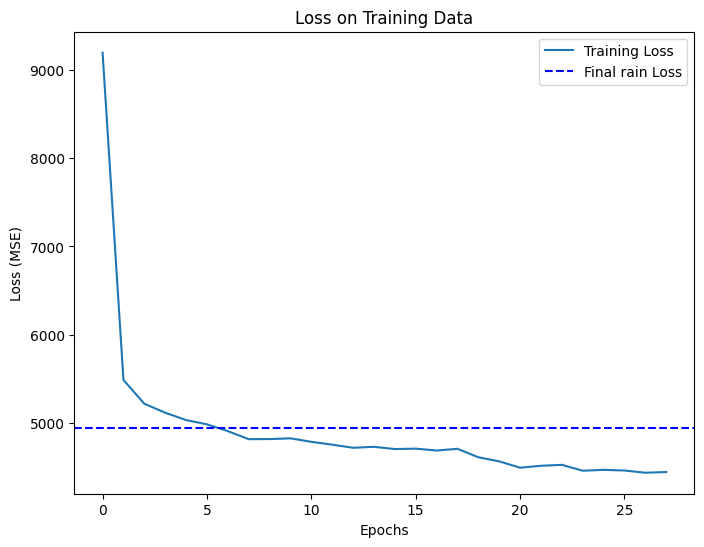

Final Training Loss (MSE): 4937.353428091462


In [24]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [16]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/pcm2.5_Kaggle-competition/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [17]:
# Load the submission CSV file
submission = pd.read_csv('/content/drive/MyDrive/pcm2.5_Kaggle-competition/subm_fixed.csv')

# Show the first few rows to inspect the content
print(submission.head())

# Check the data types and info
print(submission.info())

# Check for any missing values
print(submission.isnull().sum())


                row ID  pm2.5
0  2013-07-02 10:00:00     33
1  2013-07-02 11:00:00     32
2  2013-07-02 12:00:00     30
3  2013-07-02 13:00:00     29
4  2013-07-02 14:00:00     28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   row ID  13148 non-null  object
 1   pm2.5   13148 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 205.6+ KB
None
row ID    0
pm2.5     0
dtype: int64


In [39]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"perisnwangui","key":"754a26528ede0641545ada8a6fefa67a"}'}

In [40]:
!mkdir -p ~/.kaggle
!cp 'kaggle (1) (1).json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [41]:
!kaggle datasets list


ref                                                            title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance           Student Habits vs Academic Performance                 19512  2025-04-12 10:49:08.663000          32965        595  1.0              
adilshamim8/social-media-addiction-vs-relationships            Students' Social Media Addiction                        7851  2025-05-10 14:38:02.713000           6668         98  1.0              
atharvasoundankar/ai-developer-productivity-dataset            🧠 AI Developer Productivity Dataset                     5992  2025-05-12 08:29:17.290000           1790         63  1.0              
utkarshsharma11

In [43]:

# Submit to Kaggle
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f /content/drive/MyDrive/pcm2.5_Kaggle-competition/sample_submission .csv -m "Test Submission"

[Errno 2] No such file or directory: '/content/drive/MyDrive/pcm2.5_Kaggle-competition/sample_submission'


In [47]:
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f subm_fixed.csv -m "Message"

[Errno 2] No such file or directory: 'subm_fixed.csv'
